In [1]:
%matplotlib widget

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mplcursors
import seaborn as sns
import numpy as np

import datetime
from dateutil.parser import isoparse
from ta import momentum, trend, volatility, volume

from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)  # Optional: ensures that the line width doesn't truncate output

In [2]:
file = "daily_archives/daily_trading_data_2025-05-20.csv"

df_daily = pd.read_csv(file)

date = '2025-05-20' 
start_data_hour = '13:30'
end_data_hour = '23:00'
start_data_time = pd.to_datetime(date + ' ' + start_data_hour)
end_data_time   = pd.to_datetime(date + ' ' + end_data_hour)

df_daily["TimeStamp"] = df_daily["TimeStamp"].apply(isoparse)
# Set the TimeStamp as the index (required for resampling).
df_daily.set_index("TimeStamp", inplace=True)

df_daily = df_daily.loc[(df_daily.index >= start_data_time) & (df_daily.index <= end_data_time)]

print(df_daily.info(), '\n')

print('Number of unique rows:\n', df_daily.drop_duplicates().shape[0], '\n')
print(df_daily.nunique(), '\n')

df_daily

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 958521 entries, 2025-05-20 13:30:00.268130 to 2025-05-20 22:58:32.000730
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ConId       958521 non-null  int64  
 1   Symbol      958521 non-null  object 
 2   SecType     958521 non-null  object 
 3   Exchange    958521 non-null  object 
 4   Currency    958521 non-null  object 
 5   Bid_price   958521 non-null  float64
 6   Ask_price   958521 non-null  float64
 7   Last_price  958521 non-null  float64
 8   Volume      958521 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 73.1+ MB
None 

Number of unique rows:
 683462 

ConId              7
Symbol             7
SecType            1
Exchange           1
Currency           1
Bid_price       3244
Ask_price       3244
Last_price      3362
Volume        254526
dtype: int64 



ConId Symbol SecType Exchange Currency  \
TimeStamp                                                                
2025-05-20 13:30:00.268130      13272    UNH     STK    SMART      USD   
2025-05-20 13:30:00.519366   76792991   TSLA     STK    SMART      USD   
2025-05-20 13:30:01.271122   76792991   TSLA     STK    SMART      USD   
2025-05-20 13:30:01.271122   76792991   TSLA     STK    SMART      USD   
2025-05-20 13:30:01.271122   76792991   TSLA     STK    SMART      USD   
...                               ...    ...     ...      ...      ...   
2025-05-20 22:59:59.284526  677037673   IBIT     STK    SMART      USD   
2025-05-20 22:59:59.872972   72539702   TQQQ     STK    SMART      USD   
2025-05-20 22:59:59.872972   72539702   TQQQ     STK    SMART      USD   
2025-05-20 22:59:11.878455  166090175   BABA     STK    SMART      USD   
2025-05-20 22:58:32.000730  152486141     JD     STK    SMART      USD   

                            Bid_price  Ask_price  Last_price    Volume  
TimeStamp                                                               
2025-05-20 13:30:00.268130     323.00     323.30      323.30    7466.0  
2025-05-20 13:30:00.519366     346.31     346.40      346.40   12720.0  
2025-05-20 13:30:01.271122     346.31     346.40      346.30   12720.0  
2025-05-20 13:30:01.271122     346.26     346.40      346.30   12720.0  
2025-05-20 13:30:01.271122     346.26     346.33      346.30   12720.0  
...                               ...        ...         ...       ...  
2025-05-20 22:59:59.284526      60.83      60.88       60.85  488232.0  
2025-05-20 22:59:59.872972      70.55      70.64       70.61  660974.0  
2025-05-20 22:59:59.872972      70.55      70.64       70.61  660974.0  
2025-05-20 22:59:11.878455     125.00     125.13      125.00  116666.0  
2025-05-20 22:58:32.000730      33.91      33.95       33.91  106792.0  

[958521 rows x 9 columns]

In [42]:
# parameters

ticker = 'IBIT' 
freq = '60s'

start_plot_hour = '15:00'
end_plot_hour = '22:15'

start_session_hour = '15:30'
start_session_hour_dt = pd.to_datetime(start_session_hour).time()
start_session_time = pd.to_datetime(date + ' ' + start_session_hour)
end_session_hour = '22:00'
end_session_hour_dt = pd.to_datetime(end_session_hour).time()
end_session_time = pd.to_datetime(date + ' ' + end_session_hour)

# ema, sma parameters
ema_win = 10 # before 10
sma_win = 60 # before 60

# macd parameters
window_fast = 10 # before 30
window_slow = 60 # before 60
window_sign = 90 # before 

# bb parameters
bb_win = 90 # before 
bb_windev = 2 # before 

# rsi parameters
rsi_win = 15 # before 
low_rsi = 30 # before 
high_rsi = 70 # before 

# adx parameters
adx_thresh = 15 # before 20
adx_win = 30 # before 20

# obv parameters
obv_win = 120 # before 

# atr parameters
atr_win = 14 # before 

In [43]:
def ts_rate(ts_series):
    # Compute the duration in seconds between the max and min timestamps
    duration = (ts_series.max() - ts_series.min()).total_seconds()
    if duration == 0:
        # If duration is zero, return 0 or you can choose to return float('nan')
        return 0  
    return ts_series.nunique() / duration

# Group by 'Symbol' and compute the rate for the TS_Last_price column
rates = df_daily.groupby('Symbol').apply(lambda x: ts_rate(x.index)).reset_index(name='TimeStamps_per_sec')

print("Number of TimeStamps entries per second per Symbol:")
rates

Number of TimeStamps entries per second per Symbol:


C:\Users\Alienware\AppData\Local\Temp\ipykernel_47516\2365833682.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rates = df_daily.groupby('Symbol').apply(lambda x: ts_rate(x.index)).reset_index(name='TimeStamps_per_sec')


Symbol  TimeStamps_per_sec
0   BABA            0.687160
1   IBIT            1.043155
2     JD            0.382698
3   NVDA            3.016097
4   TQQQ            2.191547
5   TSLA            3.965523
6    UNH            1.735648

In [44]:
def last_price_rate(group):
    # Ensure the group is sorted by TimeStamp
    group = group.sort_index()
    
    # Create a boolean Series that is True when the price changes compared to the previous row
    # Note: The first row is automatically flagged, so subtract one if that isn’t desired.
    changes = group['Last_price'].ne(group['Last_price'].shift())
    change_count = changes.sum() 

    # Calculate how much time (in seconds) this group spans
    duration = (group.index.max() - group.index.min()).total_seconds()
    return change_count / duration

# Compute the rate per ticker by grouping by 'Symbol'
rates = df_daily.groupby('Symbol').apply(last_price_rate).reset_index(name='LastPriceRate')

print("Average number of Last Price changes per second per Symbol:")
rates

Average number of Last Price changes per second per Symbol:


C:\Users\Alienware\AppData\Local\Temp\ipykernel_47516\2302491163.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rates = df_daily.groupby('Symbol').apply(last_price_rate).reset_index(name='LastPriceRate')


Symbol  LastPriceRate
0   BABA       0.191306
1   IBIT       0.301641
2     JD       0.094516
3   NVDA       1.100718
4   TQQQ       0.677372
5   TSLA       1.950275
6    UNH       0.937331

In [45]:
# count, mean, standard deviation, minimum, and maximum for Last_price.
stats_last = df_daily.groupby('Symbol').agg(
    count_last_price=('Last_price', 'count'),
    mean_last_price=('Last_price', 'mean'),
    std_last_price=('Last_price', 'std'),
    min_last_price=('Last_price', 'min'),
    max_last_price=('Last_price', 'max')
)
print("Last Price Statistics by Symbol:")
stats_last

Last Price Statistics by Symbol:


count_last_price  mean_last_price  std_last_price  min_last_price  \
Symbol                                                                      
BABA               54707       124.707993        0.208844          122.96   
IBIT              100378        59.989863        0.462803           59.21   
JD                 45519        34.151552        0.154892           33.88   
NVDA              219943       133.839143        0.474696          132.62   
TQQQ              179869        70.552380        0.348043           69.40   
TSLA              245934       347.673587        2.961317          340.63   
UNH               112171       319.921146        2.873171          312.58   

        max_last_price  
Symbol                  
BABA            125.22  
IBIT             61.06  
JD               34.46  
NVDA            135.48  
TQQQ             71.29  
TSLA            354.98  
UNH             326.10

In [46]:
# count, mean, standard deviation, minimum, and maximum for Volume.
stats_volume = df_daily.groupby('Symbol').agg(
    count_volume=('Volume', 'count'),
    mean_volume=('Volume', 'mean'),
    std_volume=('Volume', 'std'),
    min_volume=('Volume', 'min'),
    max_volume=('Volume', 'max')
)
print("\nVolume Statistics by Symbol:")
stats_volume


Volume Statistics by Symbol:


count_volume    mean_volume     std_volume  min_volume  max_volume
Symbol                                                                    
BABA           54707   45505.124481   19261.179402      1608.0    116666.0
IBIT          100378  219933.904790  140056.091380      7234.0    488232.0
JD             45519   55455.662009   28285.498493       735.0    106792.0
NVDA          219943  808342.508996  417477.534960     12656.0   1603920.0
TQQQ          179869  320565.854322  184571.193146     13325.0    660974.0
TSLA          245934  683391.270235  343606.975968     12720.0   1305396.0
UNH           112171  223077.575398  108946.357753      7466.0    411552.0

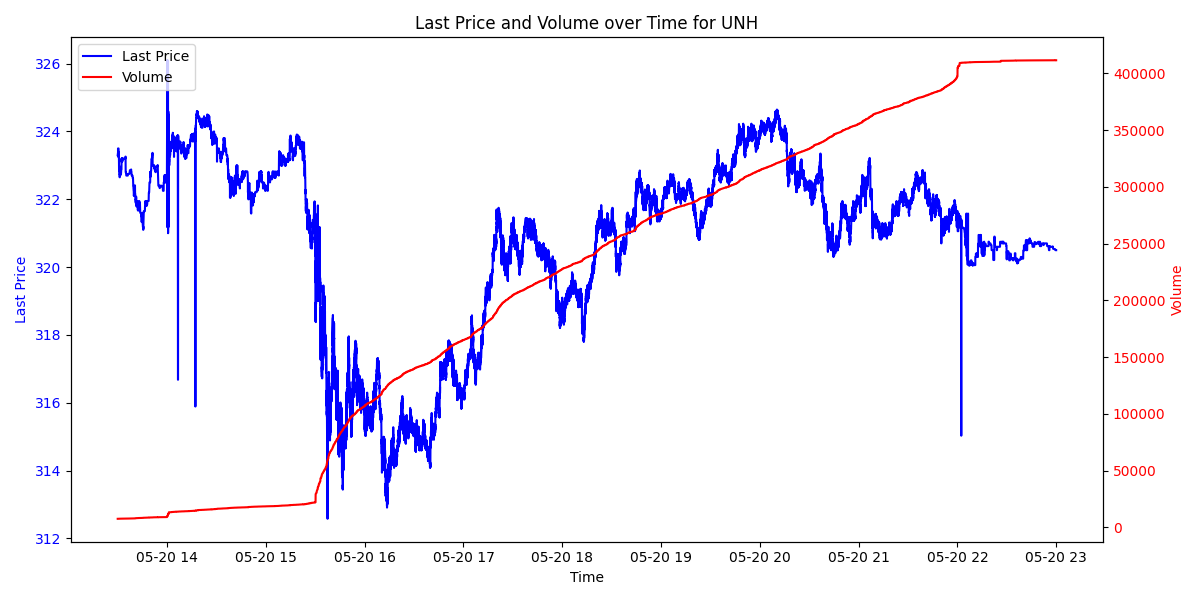

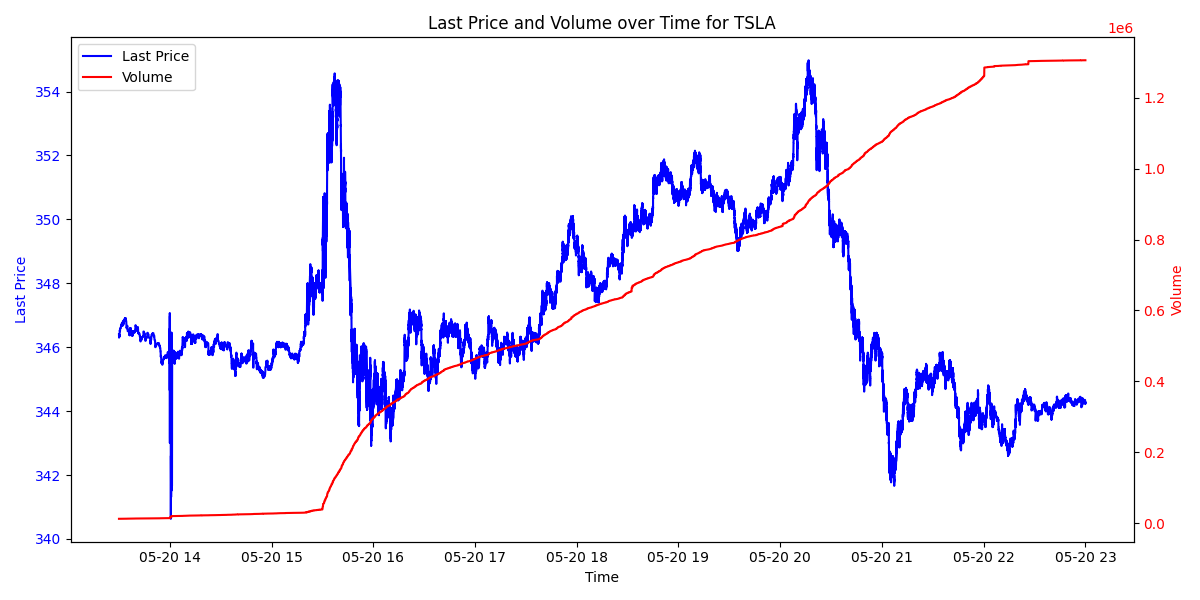

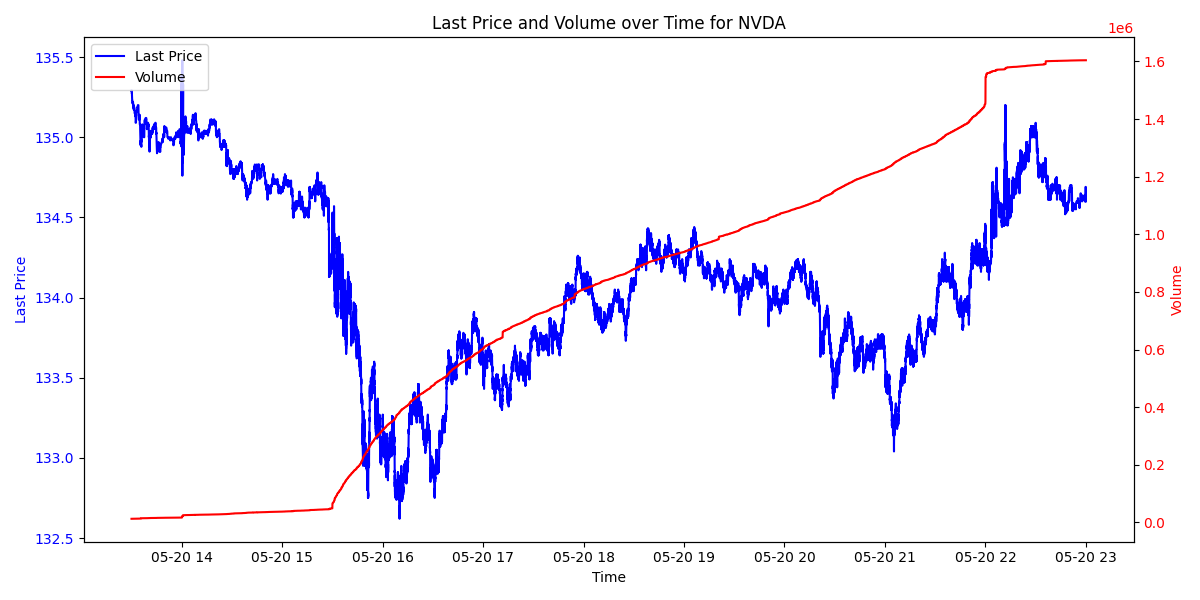

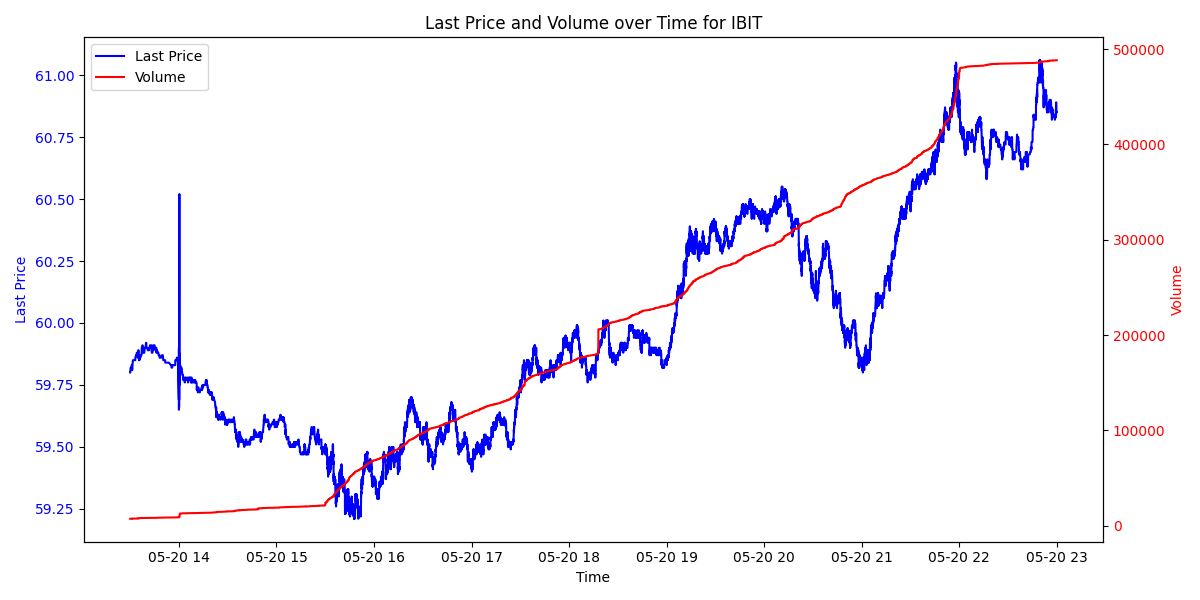

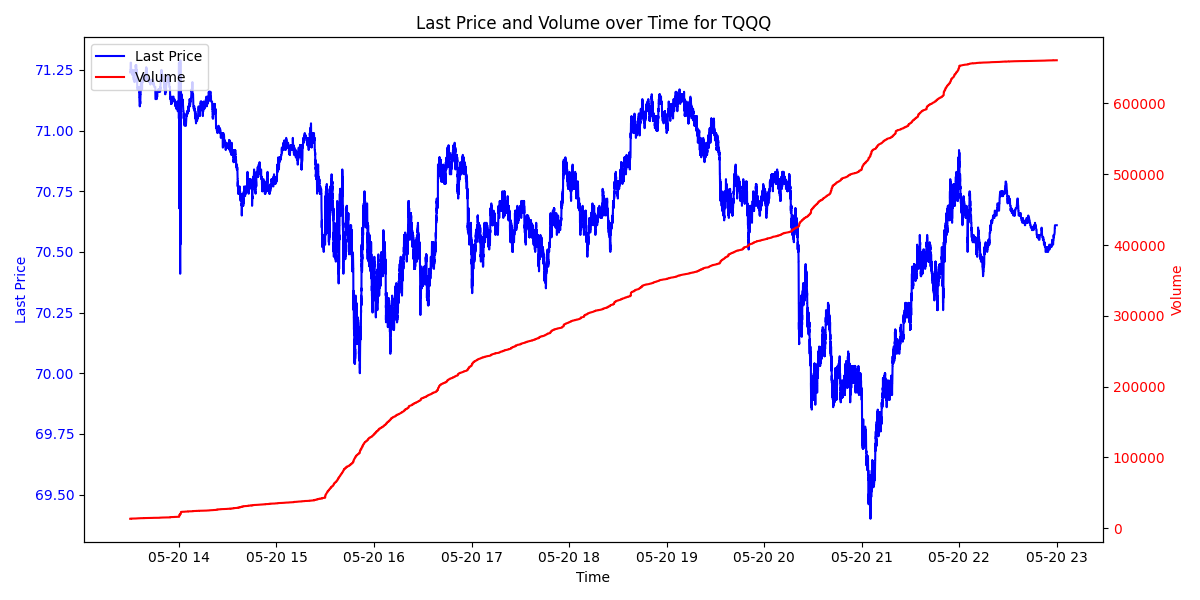

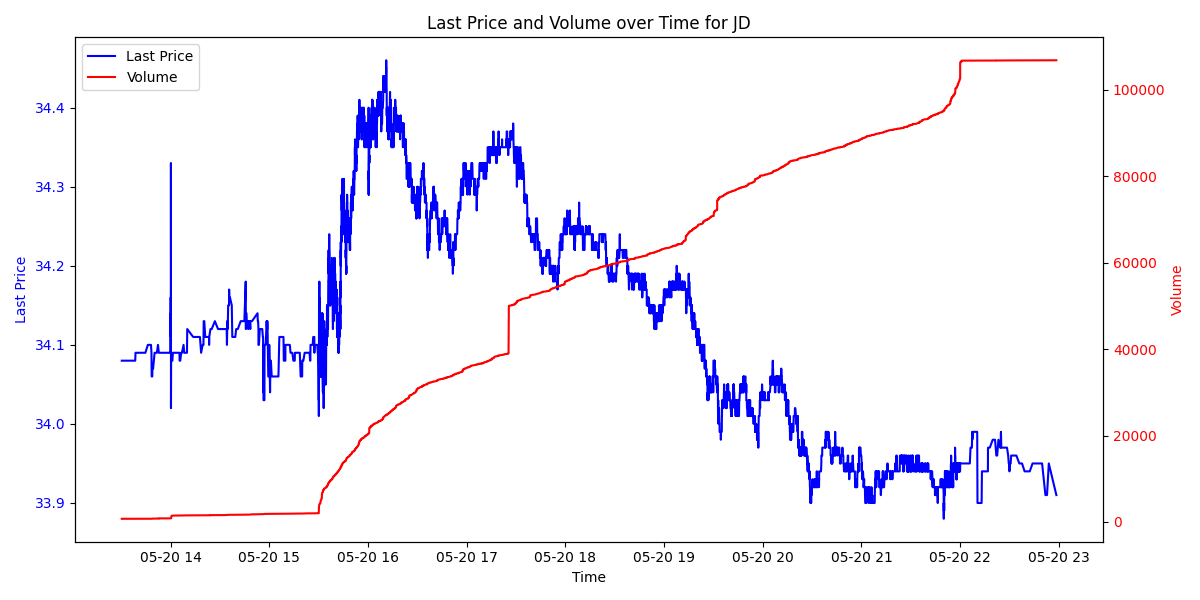

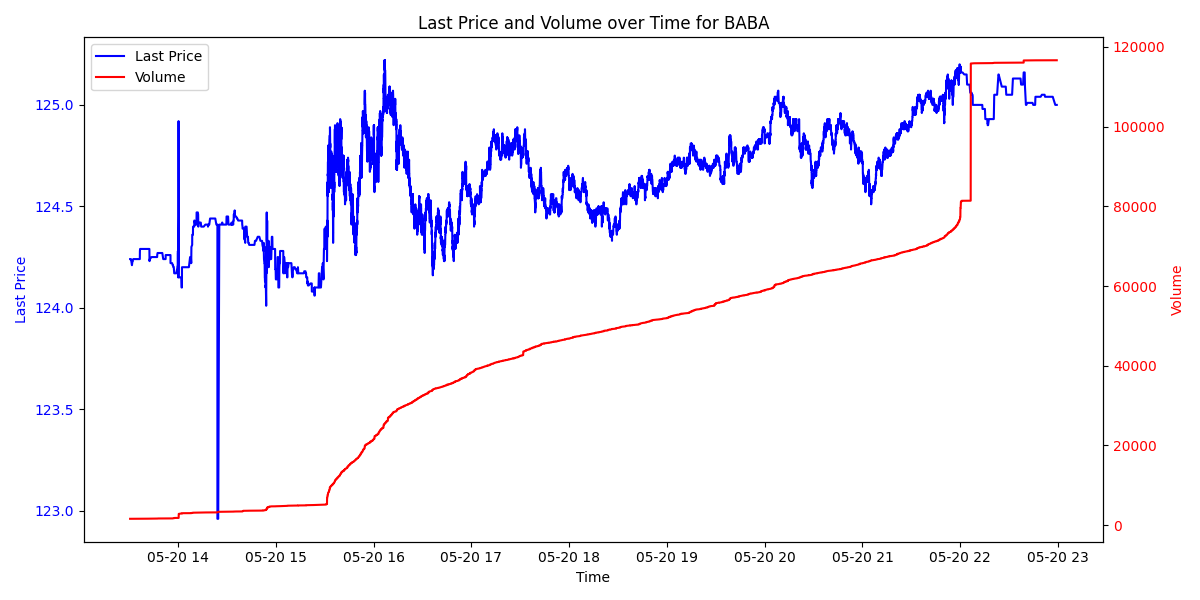

In [47]:
# Get all unique symbols.
symbols = df_daily['Symbol'].unique()


for sym in symbols:
    # Filter the data for the specific symbol
    df_sym = df_daily[df_daily['Symbol'] == sym]
    
    # Create a new figure and first axis for Last_price.
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Plot Last_price over time (using TS_Last_price).
    lns1 = ax1.plot(df_sym.index, df_sym['Last_price'], 
                    label='Last Price', color='blue')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Last Price', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    # Create a twin Axes sharing the same x-axis for Volume.
    ax2 = ax1.twinx()
    lns2 = ax2.plot(df_sym.index, df_sym['Volume'],
                    label='Volume', color='red')
    ax2.set_ylabel('Volume', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # Optionally, combine legends from both axes.
    lns = lns1 + lns2
    labels = [l.get_label() for l in lns]
    ax1.legend(lns, labels, loc='upper left')
    
    # Set a title and a bit of margin if desired.
    plt.title(f'Last Price and Volume over Time for {sym}')
    plt.tight_layout()
    plt.show()


In [48]:
# # Loop over each symbol
# for sym in symbols:
#     # Filter data for the specific symbol
#     df_sym = df_daily[df_daily['Symbol'] == sym]
    
#     # Create a new figure for the boxplot
#     plt.figure(figsize=(10,6))
    
#     # # Option 1: Using a single-variable boxplot
#     sns.boxplot(x=df_sym['Last_price'])
#     plt.xlabel('Last Price')
    
#     # Option 2 (if you prefer to show the symbol category):  
#     # sns.boxplot(x='Symbol', y='Last_price', data=df_sym)
#     # This will display the symbol on the x-axis (though there is only one category).
    
#     plt.title(f'Distribution of Last Price for {sym}')
#     plt.tight_layout()
#     plt.show()


In [49]:
# # Loop over each symbol and create an individual histogram.
# for sym in symbols:
#     df_sym = df_daily[df_daily['Symbol'] == sym]
#     plt.figure(figsize=(10, 6))
    
#     # Option 1: Using Matplotlib's plt.hist
#     plt.hist(df_sym['Last_price'], bins=30, color='steelblue', edgecolor='black')
    
#     # Option 2: Using Seaborn's histplot (uncomment if you prefer)
#     # sns.histplot(df_sym['Last_price'], bins=30, color='steelblue', edgecolor='black')
    
#     plt.xlabel('Last Price')
#     plt.ylabel('Frequency')
#     plt.title(f'Histogram of Last Price for {sym}')
#     plt.tight_layout()
#     plt.show()


In [50]:
# -------------------------------
# Visualizations
# -------------------------------   

def visualize_indicators():

    ohlc_plot = ohlc.between_time(start_plot_hour, end_plot_hour)

    # Note: We're setting sharex=False so every subplot displays its own x-axis.
    fig, axs = plt.subplots(nrows=6, ncols=1, figsize=(15.7, 48), sharex=False)
    fig.suptitle("Technical Indicators and Engineered (Unified) Signals\nwith Close Price Overlay", fontsize=20)
  
    # =======================================================
    # Row 0: Moving Averages
    # =======================================================
    feature_ma = "ma_feature"
    ax0 = axs[0]
    
    # Plot first the whole calculated feature in red, then overlay the postive buy region in green:
    ax0.plot(ohlc_plot.index, ohlc_plot[feature_ma], label="Sell Feature", color="red", linestyle="-", linewidth=1, alpha = 0.8)
    ax0.plot(ohlc_plot.index, ohlc_plot[feature_ma].where(ohlc_plot[feature_ma] > 0), label="Buy Feature", color="green", linestyle="-", linewidth=1, alpha = 0.9)
    
    ax0.axhline(0, color="gray", linestyle="--", linewidth=1, alpha=0.7)
    ax0.set_ylabel('MA features')
    ax0.legend(loc="lower left")
    ax0.set_title("EMA & SMA")

    ax0_twin = ax0.twinx()
    # plot close price, EMA and SMA on twin axis
    ax0_twin.plot(ohlc_plot.index, ohlc_plot["ema"], label="EMA", linestyle=":", color="green")
    ax0_twin.plot(ohlc_plot.index, ohlc_plot["sma"], label="SMA", linestyle=":", color="red")
    
    # Split the close price according to the feature, plotting first the complete close price continuously in black, then Overlay the buy region in blue:
    ax0_twin.plot(ohlc_plot.index, ohlc_plot["close"], label="Close", color="black", linewidth=1, alpha=0.6) 
    ax0_twin.plot(ohlc_plot.index, np.where(ohlc_plot[feature_ma] > 0, ohlc_plot["close"], np.nan), label="Close (Buy)", color="blue", linewidth=1, alpha=0.7)
    
    ax0_twin.set_ylabel("Close price, EMA, SMA")
    ax0_twin.legend(loc="lower right")
    
    _, stats_ma = simulate_generic_trading(feature_ma)
    ax0.text(0.01, 0.95, stats_ma, transform=ax0.transAxes, fontsize=9.4, color="blue")

    
    # =======================================================
    # Row 1: MACD in a Single Panel
    # =======================================================
    feature_macd = "macd_feature"
    ax1 = axs[1] 

    # Main axis: MACD indicators and MACD features
    ax1.plot(ohlc_plot.index, ohlc_plot["macd"], label="MACD", linestyle=":", color="green")
    ax1.plot(ohlc_plot.index, ohlc_plot["macd_signal"], label="Signal", linestyle=":", color="red")
    
    # Plot first the whole calculated feature in red, then overlay the postive buy region in green:
    ax1.plot(ohlc_plot.index, ohlc_plot[feature_macd], label="Sell Feature", color="red", linestyle="-", linewidth=1, alpha = 0.8)
    ax1.plot(ohlc_plot.index, ohlc_plot[feature_macd].where(ohlc_plot[feature_macd] > 0), label="Buy Feature", color="green", linestyle="-", linewidth=1, alpha = 0.9)
    
    ax1.axhline(0, color="gray", linestyle="--", linewidth=1, alpha=0.7)
    ax1.set_ylabel('MACD, MACD features')
    ax1.legend(loc="lower left")
    ax1.set_title("MACD")
    ax1.set_xlabel("Time")
    
    # Twin axis: Close Price
    ax1_twin = ax1.twinx()

    # Split the close price according to the feature, plotting first the complete close price continuously in black, then Overlay the buy region in blue:
    ax1_twin.plot(ohlc_plot.index, ohlc_plot["close"], label="Close", color="black", linewidth=1, alpha=0.6) 
    ax1_twin.plot(ohlc_plot.index, np.where(ohlc_plot[feature_macd] > 0, ohlc_plot["close"], np.nan), label="Close (Buy)", color="blue", linewidth=1, alpha=0.7)
    
    ax1_twin.set_ylabel("Close price")
    ax1_twin.legend(loc="lower right")
    
    _, stats_macd = simulate_generic_trading(feature_macd)
    ax1.text(0.01, 0.95, stats_macd, transform=ax1.transAxes, fontsize=9.4, color="blue")


    # =======================================================
    # Row 2: Bollinger Bands
    # =======================================================
    feature_bb = "bb_feature"
    ax2 = axs[2]
    
    # ax2.plot(ohlc_plot.index, ohlc_plot[feature_bb].where(ohlc_plot[feature_bb] > 0),
    #          label="Buy Feature", color="green", linestyle="-", linewidth=1)
    # ax2.plot(ohlc_plot.index, ohlc_plot[feature_bb].where(ohlc_plot[feature_bb] <= 0),
             # label="Sell Feature", color="red", linestyle="-", linewidth=1)

    # Plot first the whole calculated feature in red, then overlay the postive buy region in green:
    ax2.plot(ohlc_plot.index, ohlc_plot[feature_bb], label="Sell Feature", color="red", linestyle="-", linewidth=1, alpha = 0.8)
    ax2.plot(ohlc_plot.index, ohlc_plot[feature_bb].where(ohlc_plot[feature_bb] > 0), label="Buy Feature", color="green", linestyle="-", linewidth=1, alpha = 0.9)
    
    ax2.axhline(0, color="gray", linestyle="--", linewidth=1, alpha=0.7)
    ax2.set_ylabel("BB features")
    ax2.legend(loc="lower left")
    ax2.set_title("Bollinger Bands")
    
    # Twin axis: Close Price and Bollinger Bands indicators
    ax2_twin = ax2.twinx()
    ax2_twin.plot(ohlc_plot.index, ohlc_plot["bb_mavg"], label="BB Mid", linestyle=":", color="magenta")
    ax2_twin.plot(ohlc_plot.index, ohlc_plot["bb_hband"], label="BB High", linestyle=":", color="green")
    ax2_twin.plot(ohlc_plot.index, ohlc_plot["bb_lband"], label="BB Low", linestyle=":", color="red")

    # Split the close price according to the feature, plotting first the complete close price continuously in black, then Overlay the buy region in blue:
    ax2_twin.plot(ohlc_plot.index, ohlc_plot["close"], label="Close", color="black", linewidth=1, alpha=0.6) 
    ax2_twin.plot(ohlc_plot.index, np.where(ohlc_plot[feature_bb] > 0, ohlc_plot["close"], np.nan), label="Close (Buy)", color="blue", linewidth=1, alpha=0.7)
    
    ax2_twin.set_ylabel("Close price, BB")
    ax2_twin.legend(loc="lower right")

    _, stats_bb = simulate_generic_trading(feature_bb)
    ax2.text(0, 0.95, stats_bb, transform=ax2.transAxes, fontsize=9.4, color="blue")


    # =======================================================
    # Row 3: RSI
    # =======================================================
    feature_rsi = "rsi_feature"
    ax3 = axs[3]

    ax3.plot(ohlc_plot.index, ohlc_plot["rsi"], label="RSI", linestyle=":", color="magenta")
    ax3.axhline(low_rsi, color="magenta", linestyle="--", linewidth=0.8)
    ax3.axhline(high_rsi, color="magenta", linestyle="--", linewidth=0.8)

    # Plot first the whole calculated feature in red, then overlay the postive buy region in green:
    ax3.plot(ohlc_plot.index, ohlc_plot[feature_rsi], label="Sell Feature", color="red", linestyle="-", linewidth=1, alpha = 0.8)
    ax3.plot(ohlc_plot.index, ohlc_plot[feature_rsi].where(ohlc_plot[feature_rsi] > 0), label="Buy Feature", color="green", linestyle="-", linewidth=1, alpha = 0.9)

    ax3.axhline(0, color="gray", linestyle="--", linewidth=1, alpha=0.7)
    ax3.set_ylabel("RSI, RSI features")
    ax3.legend(loc="lower left")
    ax3.set_title("RSI")
    
    # Secondary axis: Close Price
    ax3_twin = ax3.twinx()

    # Split the close price according to the feature, plotting first the complete close price continuously in black, then Overlay the buy region in blue:
    ax3_twin.plot(ohlc_plot.index, ohlc_plot["close"], label="Close", color="black", linewidth=1, alpha=0.6) 
    ax3_twin.plot(ohlc_plot.index, np.where(ohlc_plot[feature_rsi] > 0, ohlc_plot["close"], np.nan), label="Close (Buy)", color="blue", linewidth=1, alpha=0.7)
    
    ax3_twin.set_ylabel("Close price")
    ax3_twin.legend(loc="lower right")

    _, stats_rsi = simulate_generic_trading(feature_rsi)
    ax3.text(0.01, 0.95, stats_rsi, transform=ax3.transAxes, fontsize=9.4, color="blue")
    

    # =======================================================
    # Row 4: ADX & Directional Indicators
    # =======================================================
    feature_adx = "adx_feature"
    ax4 = axs[4]
    
    ax4.plot(ohlc_plot.index, ohlc_plot["adx"], label="ADX", linestyle=":", color="magenta")
    ax4.axhline(adx_thresh, color="magenta", linestyle=":", linewidth=1)
    ax4.plot(ohlc_plot.index, ohlc_plot["plus_di"], label="+DI", linestyle=":", color="green")
    ax4.plot(ohlc_plot.index, ohlc_plot["minus_di"], label="-DI", linestyle=":", color="red")
    
    # Plot first the whole calculated feature in red, then overlay the postive buy region in green:
    ax4.plot(ohlc_plot.index, ohlc_plot[feature_adx], label="Sell Feature", color="red", linestyle="-", linewidth=1, alpha = 0.8)
    ax4.plot(ohlc_plot.index, ohlc_plot[feature_adx].where(ohlc_plot[feature_adx] > 0), label="Buy Feature", color="green", linestyle="-", linewidth=1, alpha = 0.9)
    
    ax4.axhline(0, color="gray", linestyle="--")
    ax4.set_ylabel("ADX, +DI, -DI, ADX features")
    ax4.legend(loc="lower left")
    ax4.set_title("ADX")
    ax4.set_xlabel("Time")
    
    # Twin axis: Close Price
    ax4_twin = ax4.twinx()
    
    # Split the close price according to the MA feature, plotting first the complete close price continuously in black, then Overlay the buy region in blue:
    ax4_twin.plot(ohlc_plot.index, ohlc_plot["close"], label="Close", color="black", linewidth=1, alpha=0.6) 
    ax4_twin.plot(ohlc_plot.index, np.where(ohlc_plot[feature_adx] > 0, ohlc_plot["close"], np.nan), label="Close (Buy)", color="blue", linewidth=1, alpha=0.7)
    
    ax4_twin.set_ylabel("Close price")
    ax4_twin.legend(loc="lower right")

    _, stats_adx = simulate_generic_trading(feature_adx)
    ax4.text(0.01, 0.95, stats_adx, transform=ax4.transAxes, fontsize=9.4, color="blue")


    
    # =======================================================
    # Row 5: OBV
    # =======================================================
    feature_obv = "obv_feature"
    ax5 = axs[5]
    
    ax5.plot(ohlc_plot.index, ohlc_plot["obv"], label="OBV", linestyle=":", color="green")
    ax5.plot(ohlc_plot.index, ohlc_plot["obv_sma"], label="OBV sma", linestyle=":", color="red")
    
    # Plot first the whole calculated feature in red, then overlay the postive buy region in green:
    ax5.plot(ohlc_plot.index, ohlc_plot[feature_obv], label="Sell Feature", color="red", linestyle="-", linewidth=1, alpha = 0.8)
    ax5.plot(ohlc_plot.index, ohlc_plot[feature_obv].where(ohlc_plot[feature_obv] > 0), label="Buy Feature", color="green", linestyle="-", linewidth=1, alpha = 0.9)
    
    ax5.axhline(0, color="gray", linestyle="--")
    ax5.set_ylabel("OBV, OBV sma, OBV features")
    ax5.legend(loc="lower left")
    ax5.set_title("OBV")
    
    # Twin axis: Close Price
    ax5_twin = ax5.twinx()

    # Split the close price according to the MA feature, plotting first the complete close price continuously in black, then Overlay the buy region in blue:
    ax5_twin.plot(ohlc_plot.index, ohlc_plot["close"], label="Close", color="black", linewidth=1, alpha=0.6) 
    ax5_twin.plot(ohlc_plot.index, np.where(ohlc_plot[feature_obv] > 0, ohlc_plot["close"], np.nan), label="Close (Buy)", color="blue", linewidth=1, alpha=0.7)
    
    ax5_twin.set_ylabel("Close price")
    ax5_twin.legend(loc="lower right")

    _, stats_obv = simulate_generic_trading(feature_obv)
    ax5.text(0.01, 0.95, stats_obv, transform=ax5.transAxes, fontsize=9.4, color="blue")




    
    # --------------------------------------------------
    # Set x-axis tick locator and formatter for every subplot.
    locator = mdates.MinuteLocator(byminute=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55])
    formatter = mdates.DateFormatter("%H:%M")  # Display only hour and minute
    
    for ax in axs.flatten():
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)
        plt.setp(ax.get_xticklabels(), rotation=90, ha='right')
        # Enable vertical grid lines at major ticks with a very thin line.
        ax.grid(True, which='major', axis='x', linestyle='-', linewidth=0.3, color='gray')
    
    # Then add vertical lines for start and end session:
    for ax in axs.flatten():
        ax.axvline(start_session_time , color='blue', linestyle='--', linewidth=0.7)
        ax.axvline(end_session_time , color='blue', linestyle='--', linewidth=0.7)
  
    # Increase vertical spacing between rows to clearly visualize dates on every subplot.
    plt.subplots_adjust(hspace=1.5)
    
    # Add a common x-axis label for the entire figure.
    fig.supxlabel("Time")
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    mplcursors.cursor(plt.gcf().axes, hover=True)

    plt.show()


In [51]:
# -------------------------------
# Calculate the Continuous "True Signal", shifting the pct_change, in order to use our features to predict the future pct_change
# -------------------------------

def ml_analysis():
    # Compute the percentage change in the closing price.
    ohlc["price_pct_change"] = ohlc["close"].pct_change().shift(-1)
    
    columns = feature_cols + ['price_pct_change']
    
    # 1. Normalize/standardize the data
    scaler = StandardScaler()
    df_norm = pd.DataFrame(scaler.fit_transform(ohlc[columns]), 
                           columns=columns, 
                           index=ohlc_ticker.index)
    
    # Plot histograms for all columns 
    df_norm.hist(bins=30, figsize=(15, 10))
    plt.suptitle("Histograms of all columns", y=0.92)
    plt.show()

    heatmap(df_norm)
    corr_matrix(df_norm)
    scatter(df_norm)


In [52]:
# ------------------------------------------
# (A) Create a Heatmap of the Time Evolution
# ------------------------------------------

def heatmap(df_norm):
    # Transpose so that each row represents one variable (feature/target)
    df_heatmap = df_norm.T
    
    plt.figure(figsize=(12, 4))
    sns.heatmap(df_heatmap, cmap='coolwarm', center=0, cbar_kws={'label': 'Standardized Value'})
    plt.title('Heatmap of Standardized Technical Signals and Target')
    plt.xlabel('Time Index')
    plt.ylabel('Variable')
    plt.show()

# ------------------------------------------
# (B) Create a Correlation Matrix
# ------------------------------------------

def corr_matrix(df_norm):
    # Compute the correlation matrix of your normalized DataFrame.
    corr_matrix = df_norm.corr()
    
    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Create an annotation matrix with percentage labels
    annot = corr_matrix.map(lambda x: f"{x*100:.2f}%")
    
    # Plot the heatmap using only the lower triangle and with percentage annotations.
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, mask=mask, annot=annot, cmap='coolwarm',
                center=0, fmt="", square=True, cbar_kws={"shrink": .75})
    plt.title('Correlation Matrix (Standardized Features)')
    plt.show()

# ------------------------------------------
# (C) Scatter Plots for Each Feature vs. Target
# ------------------------------------------

def scatter(df_norm):
    for feature in feature_cols:
        plt.figure(figsize=(6, 4))
        sns.scatterplot(x=df_norm[feature], y=df_norm['price_pct_change'].squeeze())
        plt.title(f'{feature} vs. price_pct_change (Standardized)')
        plt.xlabel(f'{feature} (Standardized)')
        plt.ylabel('price_pct_change (Standardized)')
        plt.axhline(0, color='gray', linestyle='--')
        plt.axvline(0, color='gray', linestyle='--')
        plt.show()


In [53]:
def simulate_generic_trading(indicator):
    """
    Simulate trading with a generic approach over the session using realistic bid/ask execution:

      - When the indicator becomes positive (and the previous signal was strictly negative or undefined),
        buy one share at the ask price.
      - When the indicator becomes negative (and the previous signal was strictly positive or undefined),
        and if you hold any shares, sell one share at the bid price.
      
    Performance statistics are computed using only the session data. In particular, the buy & hold
    benchmark is defined as buying at the ask price of the first record and selling at the bid price
    of the last record.
    
    The function computes and returns:
      - Final Net Value: Final net portfolio value from the simulation.
      - Buy & Hold Gain: The difference between the final bid and the initial ask.
      - Strategy Profit Difference: The extra profit (or loss reduction) of the simulation versus buy & hold.
      - Final Net Return (%): Final net value as a percentage of the initial ask.
      - Buy & Hold Return (%): Buy & hold gain as a percentage of the initial ask.
      - Strategy Improvement (%): The profit difference as a percentage of the buy & hold gain.
      
    The simulation DataFrame (augmented with positions, cash, net value, and trade actions) is saved as a CSV.
    """
    # First, filter the DataFrame to the trading session time.
    session_df = ohlc_ticker.between_time(start_session_hour, end_session_hour).copy()
    
    if session_df.empty:
        print("No data available in the trading session.")
        return session_df, {}
    
    position = 0  # Number of shares held
    cash = 0      # Starting cash (for simulation purposes)
    
    positions = []     # Track positions at each time step
    cash_balances = [] # Track cash balance
    net_values = []    # Track (cash + position * current bid price)
    actions = []       # Record trade actions
    
    previous_signal = None  # To store the previous indicator value
    
    for timestamp, row in session_df.iterrows():
        # Retrieve the realistic prices.
        bid_price = row['bid']
        ask_price = row['ask']
        signal = row[indicator]
        current_time = timestamp.time()
        
        if start_session_hour_dt <= current_time < end_session_hour_dt:
            action = "Hold"
            if pd.notna(signal):
                # Buy: Execute at ask price.
                if signal > 0 and (previous_signal is None or previous_signal <= 0):
                    position += 1
                    cash -= ask_price
                    action = "Buy"
                # Sell: Execute at bid price.
                elif signal < 0 and (previous_signal is None or previous_signal >= 0) and position > 0:
                    position -= 1
                    cash += bid_price
                    action = "Sell"
                else:
                    action = "Hold"
            else:
                action = "No signal"
        else:
            action = "No trade"
        
        previous_signal = signal
        
        positions.append(position)
        cash_balances.append(np.round(cash, 3))
        # For mark-to-market, we use the bid price since it is the realistic liquidation price.
        net_values.append(np.round(cash + position * bid_price, 3))
        actions.append(action)
    
    # Rebuild the session DataFrame with simulation results.
    df_sim = session_df[[indicator, 'close']].copy()
    df_sim['Ask'] = session_df['ask']
    df_sim['Bid'] = session_df['bid']
    df_sim['Volume'] = session_df['volume']
    df_sim['Position'] = positions
    df_sim['Cash'] = cash_balances
    df_sim['NetValue'] = net_values
    df_sim['Action'] = actions

    # Save the simulation DataFrame.
    df_sim.to_csv(f'backtest/df_sim_{ticker}_{indicator}.csv', index=True)
    
    # Compute performance statistics using realistic price levels:
    # Buy and hold: Buy at the first available ask and sell at the last available bid.
    initial_trade_price = session_df.iloc[0]['ask']
    final_liquidation_price = session_df.iloc[-2]['bid'] # we use the bid price of the previous sampled interval before the closing time
    buy_hold_gain = final_liquidation_price - initial_trade_price
    final_net_value = net_values[-2] # we use the net value of the previous sampled interval before the closing time
    profit_diff = final_net_value - buy_hold_gain
    
    final_net_return_pct = (final_net_value / initial_trade_price) * 100
    buy_hold_return_pct = (buy_hold_gain / initial_trade_price) * 100
    if buy_hold_gain != 0:
        if buy_hold_gain > 0:
            strategy_improve_pct = (profit_diff / buy_hold_gain) * 100
        else:
            strategy_improve_pct = (profit_diff / abs(buy_hold_gain)) * 100
    else:
        strategy_improve_pct = None

    performance_stats = {
        'Final Net Value ($)': np.round(final_net_value, 3),
        'Buy & Hold Gain ($)': np.round(buy_hold_gain, 3),
        'Strategy Profit Difference ($)': np.round(profit_diff, 3),
        'Final Net Return (%)': np.round(final_net_return_pct, 3),
        'Buy & Hold Return (%)': np.round(buy_hold_return_pct, 3),
        'Strategy Improvement (%)': np.round(strategy_improve_pct, 3)
    }
    
    # print('Performance Statistics over stock', ticker, 'for the indicator', indicator)
    # for key, value in performance_stats.items():
    #     print(key, value)
    
    return df_sim, performance_stats


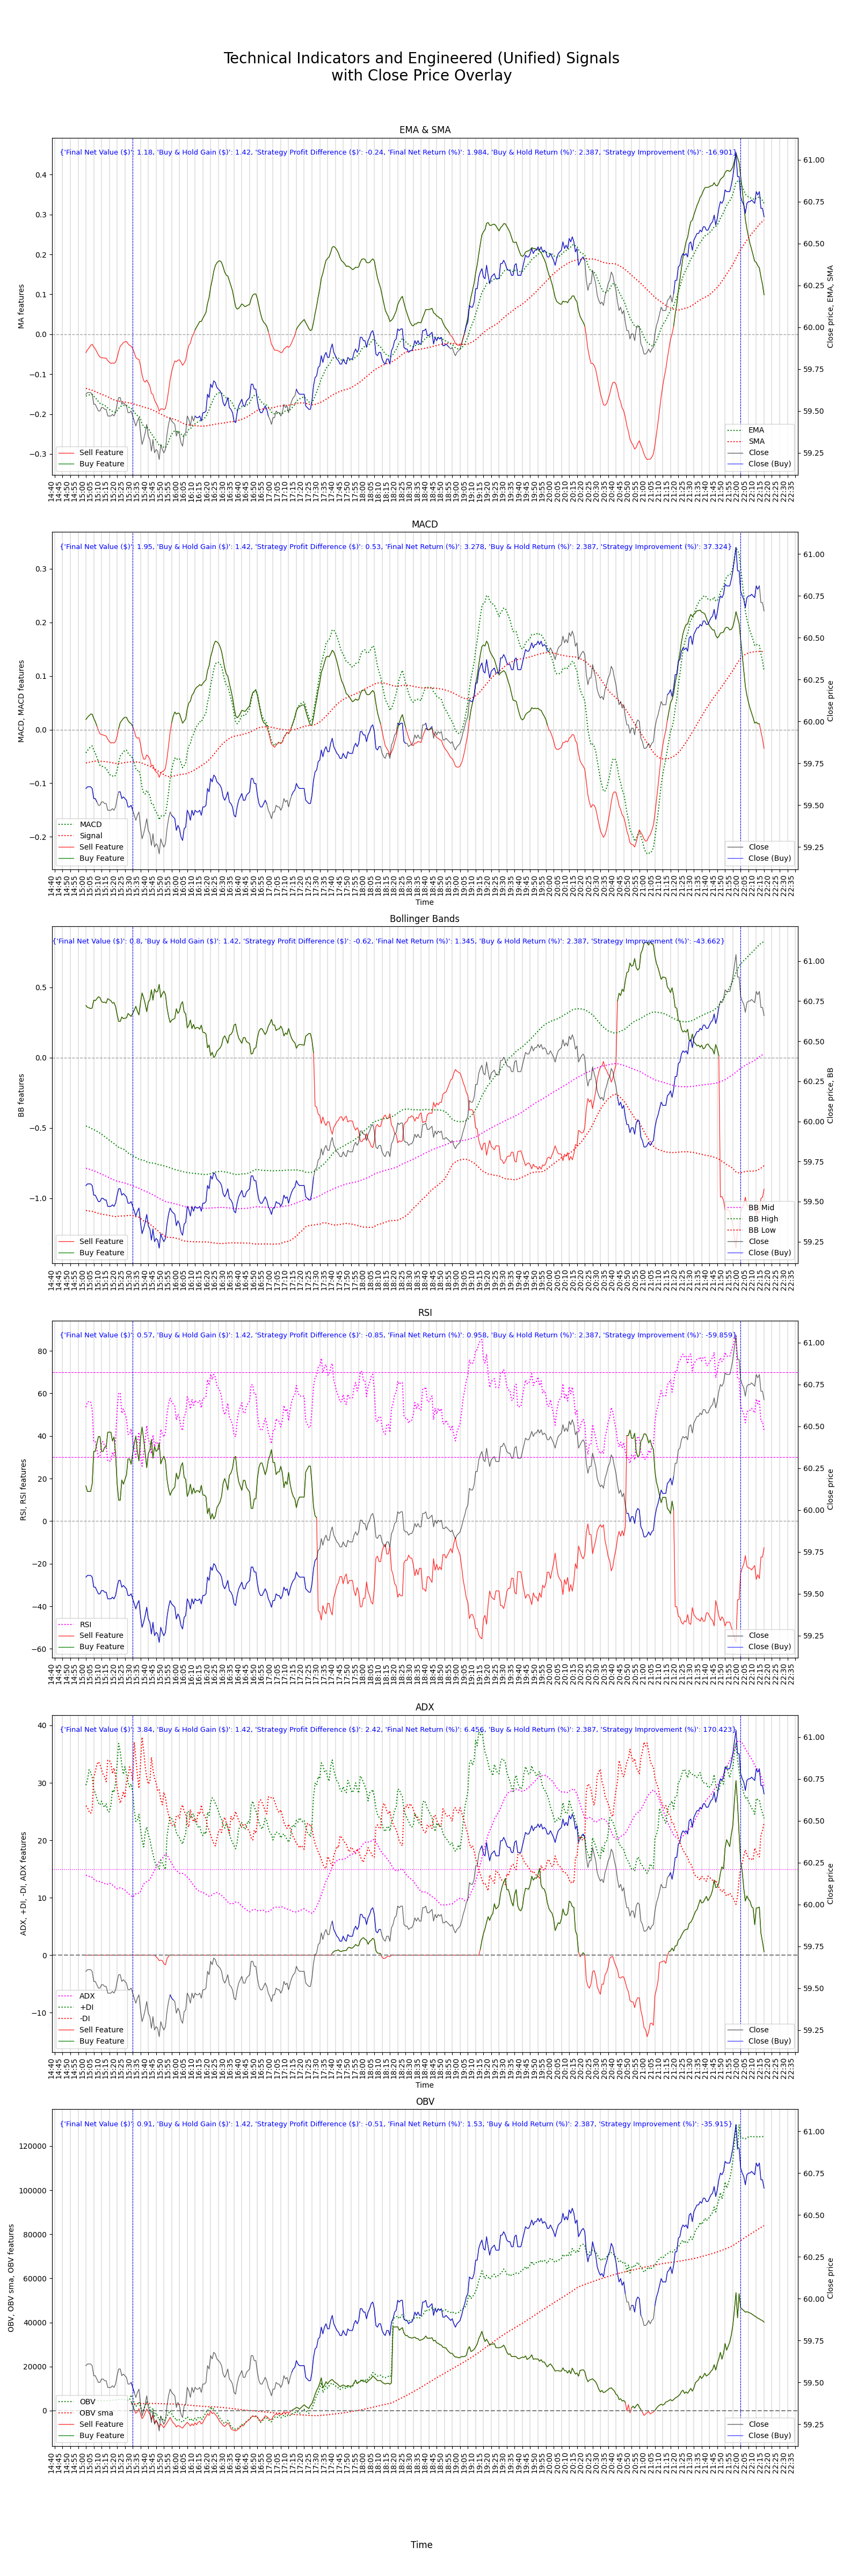

C:\Users\Alienware\AppData\Local\Temp\ipykernel_47516\1599667387.py:7: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ohlc["price_pct_change"] = ohlc["close"].pct_change().shift(-1)


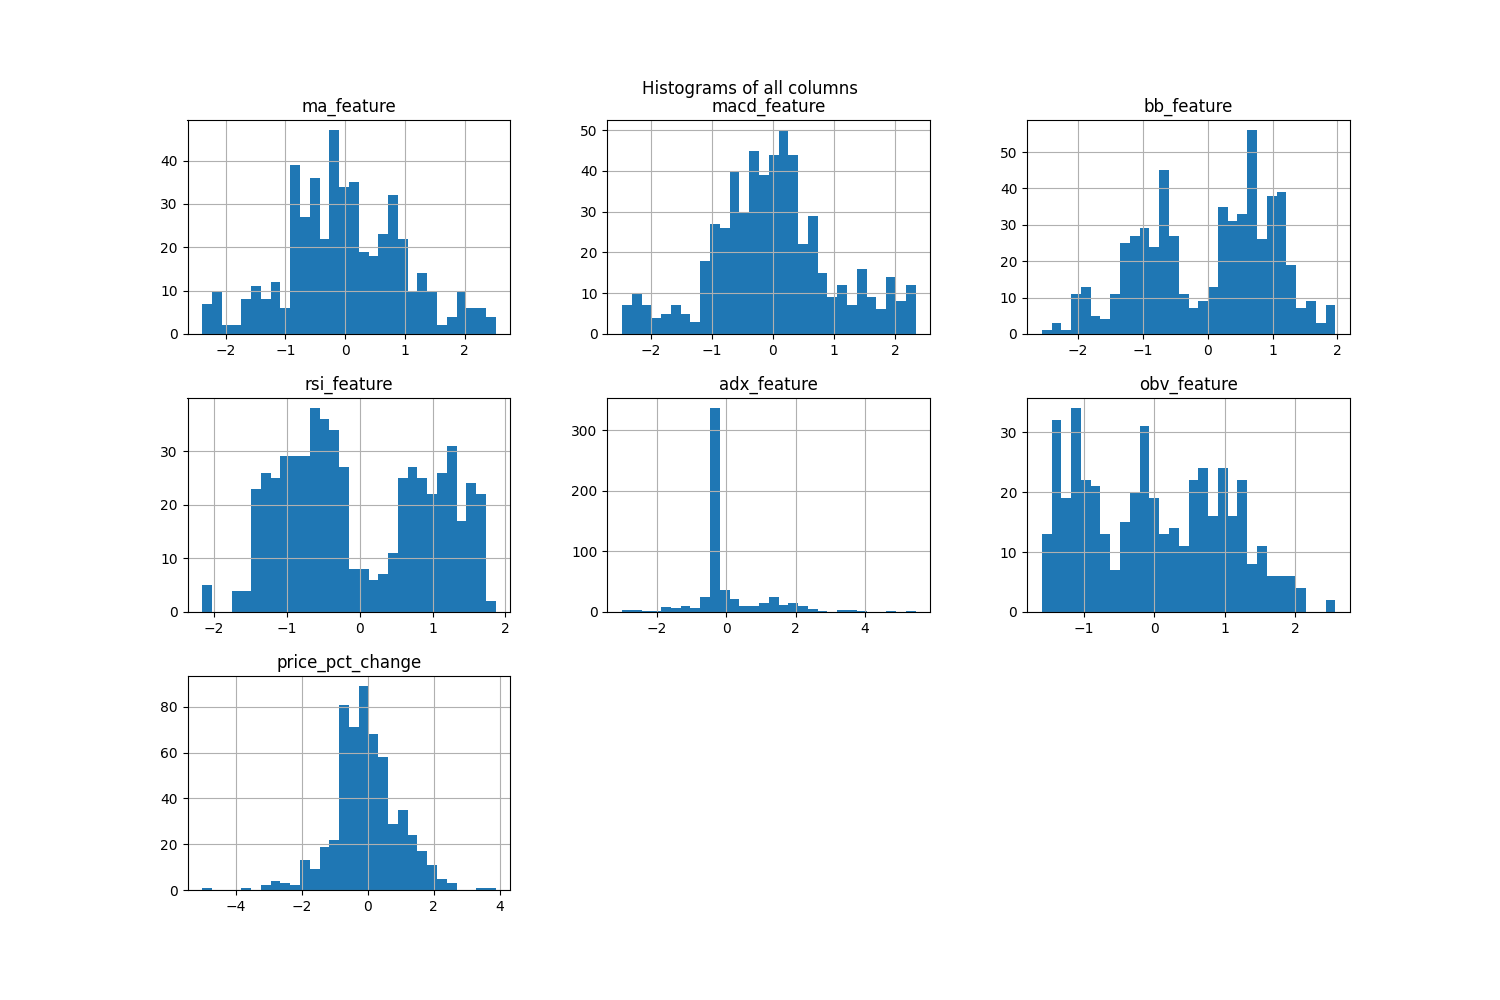

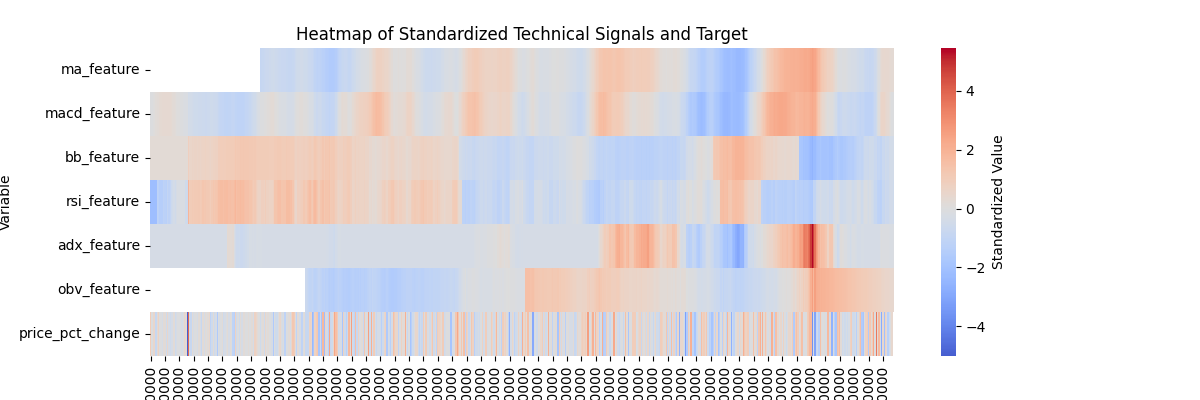

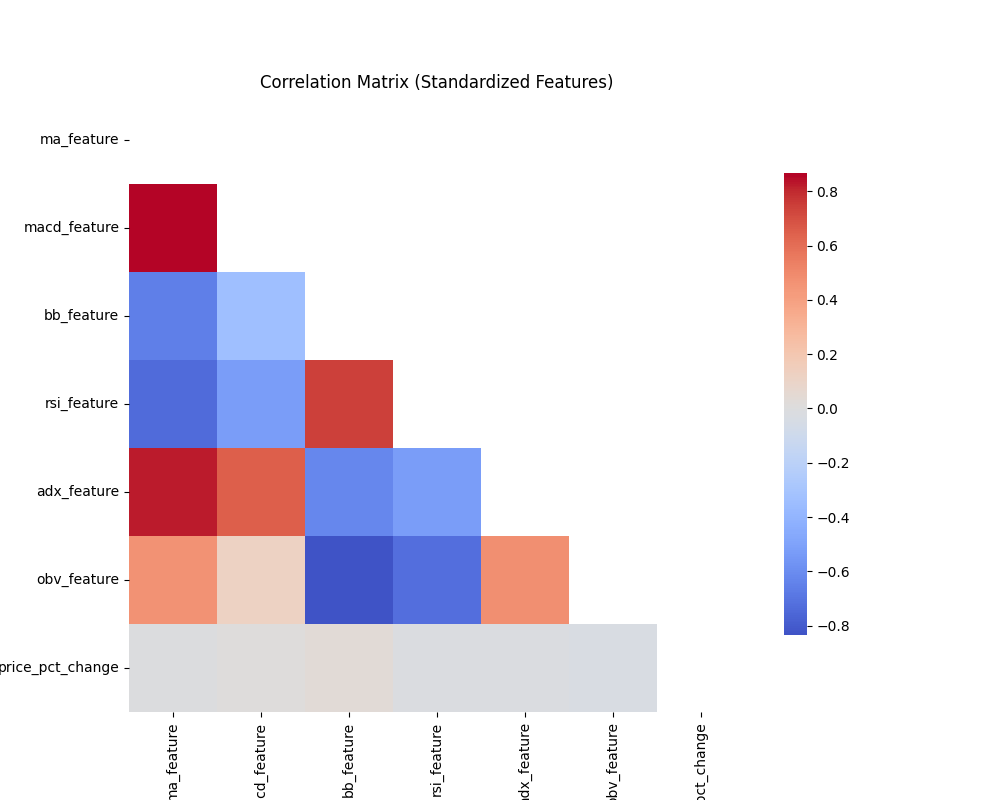

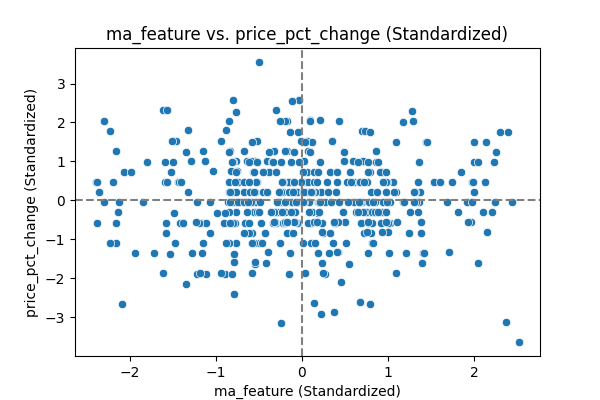

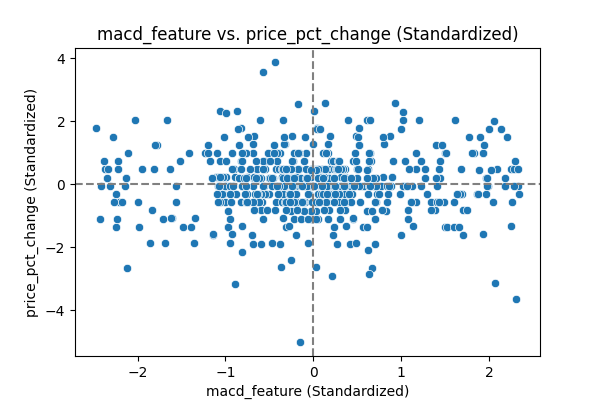

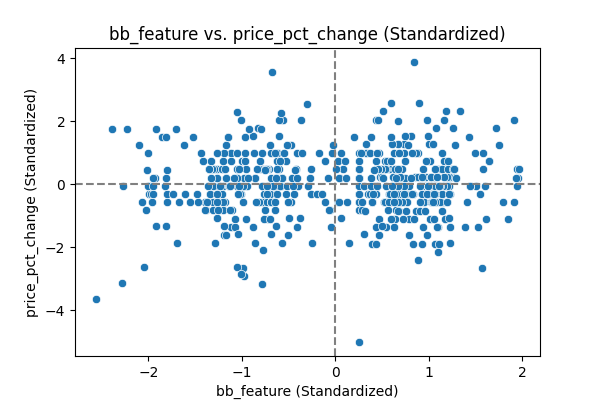

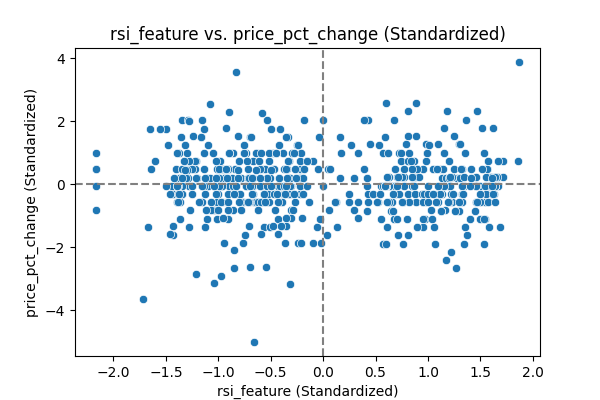

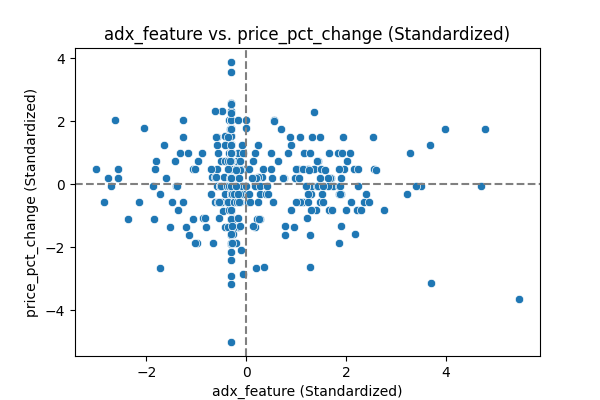

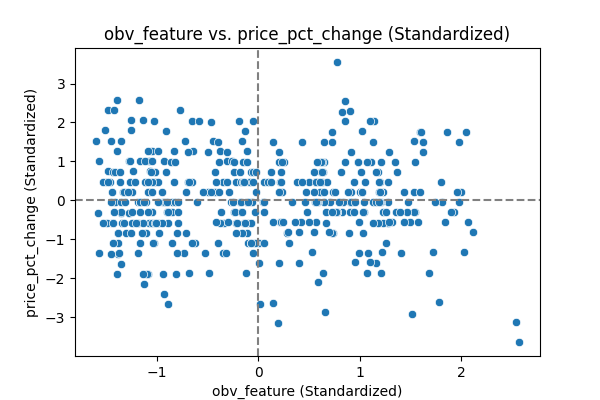

In [54]:
for symbol, group in df_daily.groupby("Symbol"):
    # Resample Last_price to compute OHLC candles over the defined frequency.
    ohlc = group["Last_price"].resample(freq).ohlc()
    
    # For cumulative volume, compute the traded volume in each interval as the difference between the last and first volume value.
    # The inline condition if len(x) > 1 else 0 ensures that if the interval has only one value, the result is 0, avoiding an IndexError.
    ohlc["volume"] = group["Volume"].resample(freq).agg(lambda x: x.iloc[-1] - x.iloc[0] if len(x) > 1 else 0)
    
    # For ask_price and bid_price, simply take the last reported value from each interval.
    ohlc["ask"] = group["Ask_price"].resample(freq).last()
    ohlc["bid"] = group["Bid_price"].resample(freq).last()
    
    # Optionally add the Symbol as a column.  
    ohlc["symbol"] = symbol

    # ================================
    # Compute Technical Indicators
    # ================================
    
    # Moving Averages: (window)-period SMA and EMA from the "close" price.
    ohlc["sma"] = ohlc["close"].rolling(window=sma_win, min_periods=sma_win).mean()
    # Use adjust=False if you prefer the recursive form that emphasizes recent data. If you need the full weighted average form, set adjust=True
    ohlc["ema"] = ohlc["close"].ewm(span=ema_win, adjust=False, min_periods=ema_win).mean() 
    
    # MACD: using standard parameters (fast=12, slow=26, signal=9)
    macd_indicator = trend.MACD(close=ohlc["close"], window_fast=window_fast, window_slow=window_slow, window_sign=window_sign, fillna=True)
    ohlc["macd"] = macd_indicator.macd()           # MACD line
    ohlc["macd_signal"] = macd_indicator.macd_signal()  # Signal line
    ohlc["macd_diff"] = macd_indicator.macd_diff()      # Histogram

    # Bollinger Bands: eg 20-period moving average with 2 standard deviations.
    bb_indicator = volatility.BollingerBands(close=ohlc["close"], window=bb_win, window_dev=bb_windev, fillna=True)
    ohlc["bb_mavg"] = bb_indicator.bollinger_mavg()   # Middle band
    ohlc["bb_hband"] = bb_indicator.bollinger_hband()   # Upper band
    ohlc["bb_lband"] = bb_indicator.bollinger_lband()   # Lower band
    
    # RSI: eg 14-period (using the close price)
    rsi_indicator = momentum.RSIIndicator(close=ohlc["close"], window=rsi_win, fillna=True)
    ohlc["rsi"] = rsi_indicator.rsi()
    
    # ADX: eg 14-period ADX indicator for trend strength.
    adx_indicator = trend.ADXIndicator(high=ohlc["high"], low=ohlc["low"], close=ohlc["close"], window=adx_win, fillna=True)
    ohlc["adx"] = adx_indicator.adx()
    ohlc["plus_di"] = adx_indicator.adx_pos()
    ohlc["minus_di"] = adx_indicator.adx_neg()
    
    # On-Balance Volume (OBV):
    # OBV calculates cumulative volume by adding volume on up moves and subtracting on down moves.
    obv_indicator = volume.OnBalanceVolumeIndicator(close=ohlc["close"], volume=ohlc["volume"], fillna=True)
    ohlc["obv"] = obv_indicator.on_balance_volume()
    ohlc["obv_sma"] = ohlc["obv"].rolling(window=obv_win).mean()

    # Average True Range (ATR): eg 14-period ATR using high, low, close.
    # Note: Here we use the OHLC prices that were derived from Last_price, which might not capture the full high/low variability.
    atr_indicator = volatility.AverageTrueRange(high=ohlc["high"], low=ohlc["low"], close=ohlc["close"], window=atr_win, fillna=True)
    ohlc["atr"] = atr_indicator.average_true_range()

    
    # ================================
    # Generate Trading Features from Indicators
    # ================================
    
    # 1. Moving Averages Feature (already one unique value)
    ohlc["ma_feature"] = np.round(
        ohlc["ema"] - ohlc["sma"], 3)

    
    # 2. MACD Feature (already unique)
    ohlc["macd_feature"] = np.round(
        ohlc["macd_diff"], 3) # ohlc["macd"] - ohlc["macd_signal"]

    
    # 3. Bollinger Bands
    #  Define the state based on crossing events:
    #    +1 when close goes below the lower Bollinger band,
    #    -1 when close goes above the upper Bollinger band.
    state = np.where(ohlc["close"] < ohlc["bb_lband"], 1,
                     np.where(ohlc["close"] > ohlc["bb_hband"], -1, np.nan))
    
    # Convert to a pandas Series and forward-fill the last known state.
    # This carries the most recent crossing until a new one occurs.
    state = pd.Series(state, index=ohlc.index).ffill().fillna(0)
    
    # Compute the feature continuously based on the current state.
    # For a buy state (state > 0): feature = (upper band - close)
    # For a sell state (state < 0): feature = (lower band - close)
    ohlc["bb_feature"] = np.round(
                            np.where(state > 0,
                                  ohlc["bb_hband"] - ohlc["close"],
                                  np.where(state < 0,
                                           ohlc["bb_lband"] -  ohlc["close"],
                                           0)),3)
    
    # 4. RSI Feature:
    #  Create a state signal:
    #    +1 when RSI goes below low_rsi (buy event),
    #    -1 when RSI goes above high_rsi (sell event),
    #    otherwise NaN.
    state = np.where(ohlc["rsi"] < low_rsi, 1,
                     np.where(ohlc["rsi"] > high_rsi, -1, np.nan))
    
    # Convert to a Pandas Series and forward-fill so that the last crossing's state remains in effect.
    state = pd.Series(state, index=ohlc.index).ffill().fillna(0)
    
    #  Calculate the RSI feature continuously based on state:
    #    - In buy state (state = 1): feature = (high_rsi - RSI)   → a positive value.
    #    - In sell state (state = -1): feature = (low_rsi - RSI)   → a negative value.
    #    - Otherwise, the feature is 0.
    ohlc["rsi_feature"] = np.round(np.where(
        state > 0,
        high_rsi - ohlc["rsi"],
        np.where(state < 0, low_rsi - ohlc["rsi"], 
                 0)), 3)

    
    # 5. ADX with Directional Indicators Feature:
    # Only produce a signal when ADX >= adx_thresh.
    # If plus_di > minus_di, signal = (plus_di - minus_di) * (adx/adx_thresh)
    # If minus_di > plus_di, signal = -(minus_di - plus_di) * (adx/adx_thresh)
    ohlc["adx_feature"] = np.round(
                            np.where(
                                ohlc["adx"] > adx_thresh,
                                np.where(
                                    ohlc["plus_di"] > ohlc["minus_di"],
                                    (ohlc["plus_di"] - ohlc["minus_di"]) * (ohlc["adx"] - adx_thresh) * 0.05, # factor 0.05 for better visualization
                                    -(ohlc["minus_di"] - ohlc["plus_di"]) * (ohlc["adx"] - adx_thresh) * 0.05 # factor 0.05 for better visualization
                                ), 0), 3)

    
    # 6. OBV Feature:
    # continuous feature positive with magnitude reflecting accumulation (buy) and negative with magnitude reflecting distribution (sell).
    ohlc["obv_feature"] = np.round(ohlc["obv"] - ohlc["obv_sma"], 3)


    if (ohlc["symbol"] == ticker).all():

        # List all columns that end with '_feature'
        feature_cols = [col for col in ohlc.columns if col.endswith('_feature')]
        # Save the filtered DataFrame into the dictionary 
        ohlc_ticker = ohlc[feature_cols + ['close', 'bid', 'ask', 'volume']]

        visualize_indicators()

        ml_analysis()

